In [1]:
import numpy as np
from matplotlib import pyplot as plt
from timeit import default_timer

import paddle
from paddle.io import DataLoader, TensorDataset

paddle.seed(0)
np.random.seed(0)
paddle.set_device('gpu')

/home/lunhao/miniconda3/envs/paddleAnd310/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


Place(gpu:0)

# Load data

In [2]:
PATH = "/home/lunhao/Replication/AiScience/geofno-paddle/data/training/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]



PATH = "/home/lunhao/Replication/AiScience/geofno-paddle/data/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 300
inputX_test_raw = np.load(INPUT_X)[:,0:n_data]
inputY_test_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_test_raw = np.load(INPUT_para)[:,0:n_data]
output_test_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


# Visualize sampled data

Text(0, 0.5, 'L_p')

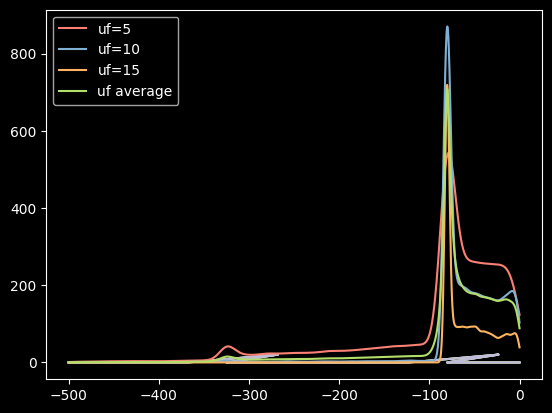

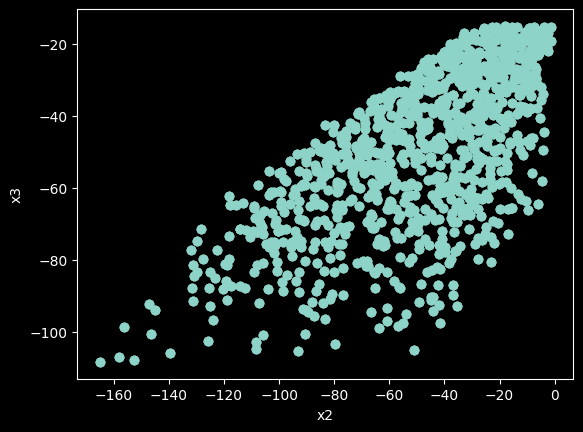

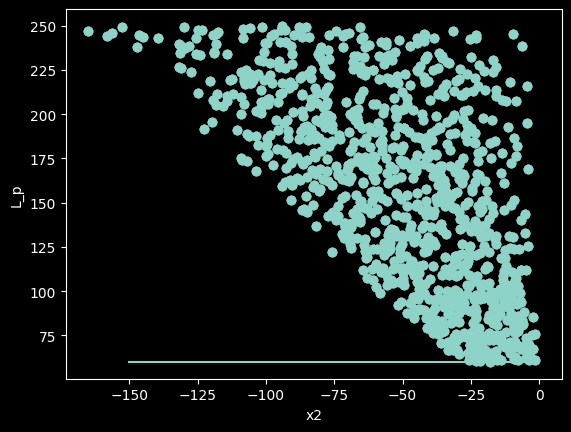

In [3]:

plt.figure()
test_id = 0
plt.plot(inputX_raw[:,3*test_id], inputY_raw[:,3*test_id])
plt.plot(inputX_raw[:,3*test_id+1], inputY_raw[:,3*test_id+1])
plt.plot(inputX_raw[:,3*test_id+2], inputY_raw[:,3*test_id+2])
sample, uf, L_p, x1, x2, x3, h = inputPara_raw[:,3*test_id]

xx = np.linspace(-L_x, 0, N_s)
plt.plot(xx, output_raw[:,3*test_id], label="uf=5")
plt.plot(xx, output_raw[:,3*test_id+1], label="uf=10")
plt.plot(xx, output_raw[:,3*test_id+2], label="uf=15")
plt.plot(xx, (output_raw[:,3*test_id]+output_raw[:,3*test_id+1]+output_raw[:,3*test_id+2])/3, label="uf average")
plt.legend()

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel("x2")
plt.ylabel("x3")

plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.plot(np.linspace(-150,0,100), np.linspace(60,60,100))
plt.xlabel("x2")
plt.ylabel("L_p")


# Process data

In [4]:
# zero tests 

ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001
epochs = 2#1001
step_size = 100
gamma = 0.5


modes = 64
width = 64
s = N_s

################################################################
# preprocess training data
################################################################
inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0
intputX = paddle.to_tensor(inputX, dtype='float32').transpose([1,0])
intputY = paddle.to_tensor(inputY, dtype='float32').transpose([1,0])

tensor1 = paddle.randn([1000, 2001], dtype='float32')  # 使用randn生成随机数据作为示例
tensor2 = paddle.randn([1000, 2001], dtype='float32')  # 同样生成随机数据
tensor1 = intputX
tensor2 = intputY

input = paddle.stack([tensor1, tensor2], axis=2)
# input = paddle.stack([inputX, inputY], axis=2)
output = paddle.to_tensor(output, dtype='float32').transpose([1,0])
index = paddle.randperm(ntrain)
train_index = index[:ntrain]
x_train = paddle.index_select(input, train_index)
y_train = paddle.index_select(output, train_index)
x_train = x_train.reshape([ntrain, s, 2])
train_loader = DataLoader(TensorDataset([x_train, y_train]), batch_size=batch_size, shuffle=True)


################################################################
# preprocess test data
################################################################
inputX_test = inputX_test_raw[:, 0::3]
inputY_test = inputY_test_raw[:, 0::3]
inputPara_test = inputPara_test_raw[:, 0::3]
output_test = (output_test_raw[:, 0::3] + output_test_raw[:, 1::3] + output_test_raw[:, 2::3])/ 3.0
inputX_test = paddle.to_tensor(inputX_test, dtype='float32').transpose([1,0])
inputY_test = paddle.to_tensor(inputY_test, dtype='float32').transpose([1,0])
input_test = paddle.stack([inputX_test, inputY_test], axis=2)
output_test = paddle.to_tensor(output_test, dtype='float32').transpose([1,0])
x_test = input_test.reshape([ntest, s, 2])
y_test = output_test
test_loader = DataLoader(TensorDataset([x_test, y_test]), batch_size=batch_size, shuffle=True)

W0831 21:38:17.676788 61222 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 6.1, Driver API Version: 12.0, Runtime API Version: 11.8
W0831 21:38:18.026093 61222 gpu_resources.cc:164] device: 0, cuDNN Version: 8.7.


In [5]:
# !python -c "import ppsci; ppsci.run_check()"

: 

# Train Geo-FNO

Here we predicted the averaged bacteria distribution for three different flow rates.

In [6]:
# def count_params(model):
#     total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     return total_params

loss_data = np.zeros((3, epochs))

if __name__ == "__main__":
    ################################################################
    # training and evaluation
    ################################################################
    padding=100
    input_channel=2
    output_np=s

    from catheter import FNO1d
    model = FNO1d(modes, width, padding, input_channel=input_channel, output_np=output_np)
    print(count_params(model))

    optimizer = paddle.optimizer.Adam(parameters=model.parameters(),learning_rate=learning_rate, weight_decay=1e-4)
    scheduler = paddle.optimizer.lr.StepDecay(learning_rate=optimizer.get_lr(), step_size=step_size, gamma=gamma)
    optimizer.set_lr_scheduler(scheduler)

    from utilities3 import *
    myloss = LpLoss(size_average=False)

    
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_l2 = 0

        for batch_id, (x, y) in enumerate(train_loader()):

            out = paddle.exp(model(x))
            

            loss = myloss(out.view([batch_size, -1]), y.view([batch_size, -1]))
            print('###################################################', loss.item())
              
            loss.backward(retain_graph=True)

            optimizer.step()
            # 梯度清零
            optimizer.clear_grad()
            train_l2 += loss.item()
        print('-------------------------------------------------', train_l2)
        print(model.conv4.weights1)
        # model.eval()
        # test_l2 = 0.0
        # for batch_id, (x, y) in enumerate(test_loader()):

        #     out = paddle.exp(model(x))

        #     # 计算损失与精度
        #     test_l2 += myloss(out.view([batch_size, -1]), y.view([batch_size, -1])).item()

        # train_l2 /= ntrain
        # test_l2 /= ntest

        # t2 = default_timer()
        # print(ep, t2 - t1, train_l2, test_l2)
        
        # loss_data[:, ep] = ep, train_l2, test_l2
        # # save nn
        # if ep%step_size==0:
        #     paddle.save(model.state_dict(), 'catheter_plain_length_model_1d'+str(ep)+'..pdmodel')


    

FNO1d(
  (fc0): Linear(in_features=2, out_features=64, dtype=float32)
  (conv0): SpectralConv1d()
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (conv3): SpectralConv1d()
  (conv4): SpectralConv1d()
  (w0): Conv1D(64, 64, kernel_size=[1], data_format=NCL)
  (w1): Conv1D(64, 64, kernel_size=[1], data_format=NCL)
  (w2): Conv1D(64, 64, kernel_size=[1], data_format=NCL)
  (w3): Conv1D(64, 64, kernel_size=[1], data_format=NCL)
  (fc1): Linear(in_features=64, out_features=128, dtype=float32)
  (fc2): Linear(in_features=128, out_features=1, dtype=float32)
)


W0831 21:38:39.296165 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:38:50.430567 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:40:16.136862 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:40:20.445647 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:40:26.072088 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:40:33.982728 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:40:42.075503 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:40:47.442508 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:40:50.702405 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:41:17.822551 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:41:34.294495 61292 sampler.cpp:194] bvar is busy at sampling for 2 seconds!
W0831 21:41:51.695552 61292 sampler.cpp:194] bvar is busy at samp

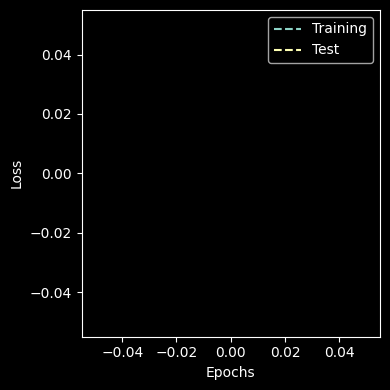

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(loss_data[0, :], loss_data[1, :], "--", label="Training")
plt.plot(loss_data[0, :], loss_data[2, :], "--", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("Loss.pdf")

# Verify the Geo-FNO model

In [ ]:
# PATH = "/groups/esm/dzhuang/Catheter/allparam/length/test/"
# INPUT_X = PATH+"x_1d_structured_mesh.npy"
# INPUT_Y = PATH+"y_1d_structured_mesh.npy"
# INPUT_para = PATH+"data_info.npy"
# OUTPUT = PATH+"density_1d_data.npy"

# n_data = 300
# inputX_raw = np.load(INPUT_X)[:,0:n_data]
# inputY_raw = np.load(INPUT_Y)[:,0:n_data]
# inputPara_raw = np.load(INPUT_para)[:,0:n_data]
# output_raw = np.load(OUTPUT)[:,0:n_data]
# inputPara_raw = np.load(INPUT_para)[:,0:n_data]

# N_s, L_x = 2001, 500


# # PATH = "/groups/esm/dzhuang/Catheter/allparam/period/"
# # INPUT_INFO = PATH+"data_info.npy"
# # dataInfo = np.load(INPUT_INFO)


# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model = torch.load("catheter_plain_length_model_1d1000", map_location=device)


# ntest = 100


# modes = 64
# width = 64
# # nx ny
# s = N_s

# ################################################################
# # load data and data normalization
# ################################################################
# inputX = inputX_raw[:, 0::3]
# inputY = inputY_raw[:, 0::3]
# inputPara = inputPara_raw[:, 0::3]
# output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0




# inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
# inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
# input = torch.stack([inputX, inputY], dim=-1)
# output = torch.tensor(output, dtype=torch.float).permute(1,0)

# x_test = input.reshape(ntest, s, 2) 
# y_test = output 


# for sample_id in [0,8]:
#     sample, uf, L_p, x1, x2, x3, h = inputPara[:, sample_id]
#     mesh = x_test[sample_id, :, :]
    
#     y_test_pred = torch.exp(model(x_test[sample_id:sample_id+1,:,:].to(device))).detach().cpu().numpy().flatten()
#     print("rel. error is ", np.linalg.norm(y_test_pred - y_test[sample_id, :].numpy())/np.linalg.norm(y_test[sample_id, :]))
#     xx = np.linspace(-L_x, 0 ,N_s)
#     plt.figure(figsize=(5,4))
    
    
    
#     plt.plot(mesh[:, 0], mesh[:, 1], color="C1", label="Channel geometry")
#     plt.plot(mesh[:, 0], 100-mesh[:, 1], color="C1")
    
#     plt.plot(xx, y_test[sample_id, :], "--o", color="red", markevery=len(xx)//10, label="Reference")
#     plt.plot(xx, y_test_pred, "--*", color="C2", fillstyle='none', markevery=len(xx)//10, label="Predicted bacteria distribution")

#     plt.xlabel(r"x")
    
#     plt.legend()
#     plt.tight_layout()
#     plt.savefig("Validation."+str(sample_id)+".pdf")
    

: 